#  Credit Default

## Описание задачи

Цель - предсказать факт невыполнения кредитных обязательств 

Зачем?  

_В банках, страховых компаниях:_
- Принять решение о выдаче кредита/страховки

## Содержание
* [1. Загрузка данных](#load)
* [2. EDA](#eda)
    * [2.1. Целевая переменная](#target)
    * [2.2. Остальные переменные](#other_val)
        * [2.2.1. Количественные переменные](#numeric)
        * [2.2.2. Категориальные переменные](#category)
        * [2.2.3. Визуализация переменных - гистограммы](#hist)
        * [2.2.4. Матрица корреляции](#corr_matrix)
    * [2.3. Корреляция целевой переменной с базовыми](#target_corr)
* [3. Обработка исходных данных](#prep)
    * [3.1. Обработка выбросов](#outlier)
        * [3.1.1. Сredit score](#credit_score)
        * [3.1.2. Current credit balance](#current_credit_balance)
        * [3.1.3. Monthly debt](#monthly_debt)
        * [3.1.4. Credit loan amount](#credit_loan_amount)
        * [3.1.5. Maximum open credit](#maximum_open_credit)
    * [3.2. Обработка пропусков](#nan)
        * [3.2.1. Annual income](#annual_income)
        * [3.2.2. Years in current job](#years_in_current_job)
        * [3.2.3. Bankruptcies](#bankruptcies)
        * [3.2.4. Credit score](#credit_score_nan)
        * [3.2.5. Month since last delinquent](#month_since_last_delinquent)
* [4. Построение новых признаков](#new_features)
    * [4.1. Years in current job num](#years_num)
    * [4.2. Tax liens](#tax_liens)
    * [4.3. Number of credit problems](#number_of_credit_problems)
    * [4.4. Bankruptcies bin](#bankruptcies_bin)
    * [4.5. Term](#term)
    * [4.6. Monthly debt share](#monthly_debt_share)
    * [4.7. Loan amount share](#loan_amount_share)
* [5. Сохранение обработанных данных](#backup)
* [6. Отбор признаков](#feature_select)
* [7. Разбиение на train и test](#ds_separating)
* [8. Построение модели](#catb)
    * [8.1. Подбор параметров модели](#parameters)
    * [8.2. Обучение и оценка итоговой модели](#fin_model)
* [9. Прогнозирование на тестовом датасете](#predictions)

## Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

import catboost as catb
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    """Функция для отображения результатов проверки модели"""
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    """Функция для проверки модели"""
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
plt.rcParams.update({'font.size': 14})

**Пути к директориям и файлам**

In [6]:
TRAIN_DATASET_PATH = './train.csv'
PREPARED_DATASET_PATH = './train_prepared.csv'
TEST_DATASET_PATH = './test.csv'

# 1. Загрузка данных <a class='anchor' id='load'>

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')

**Описание датасета**

Статистические данные о заемщиках.
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* **Current Credit Balance** - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка) - **target величина**

In [9]:
train_df.shape

(7500, 17)

In [10]:
train_df.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [11]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

# 2. EDA <a class='anchor' id='eda'>

## 2.1. Целевая переменная <a class='anchor' id='target'>

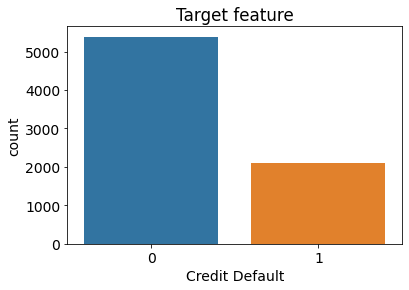

In [13]:
sns.countplot(x=train_df['Credit Default'])
plt.title('Target feature')

plt.show()

## 2.2. Остальные переменные <a class='anchor' id='other_val'>

### 2.2.1. Количественные переменные <a class='anchor' id='numeric'>

In [14]:
df_num_features = train_df.select_dtypes(include=['float64'])
df_num_features.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,482087.0,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,99999999.0,47386.0,7914.0,749.0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,264968.0,394972.0,18373.0,737.0
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,99999999.0,308389.0,13651.0,742.0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,121396.0,95855.0,11338.0,694.0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,125840.0,93309.0,7180.0,719.0


### 2.2.2. Категориальные переменные <a class='anchor' id='category'>

In [15]:
df_cat_features = train_df.select_dtypes(include=['category', 'object'])
df_cat_features.head()

,Home Ownership,Years in current job,Purpose,Term
0,Own Home,NaN,debt consolidation,Short Term
1,Own Home,10+ years,debt consolidation,Long Term
2,Home Mortgage,8 years,debt consolidation,Short Term
3,Own Home,6 years,debt consolidation,Short Term
4,Rent,8 years,debt consolidation,Short Term


### 2.2.3. Визуализация переменных - гистограммы <a class='anchor' id='hist'>

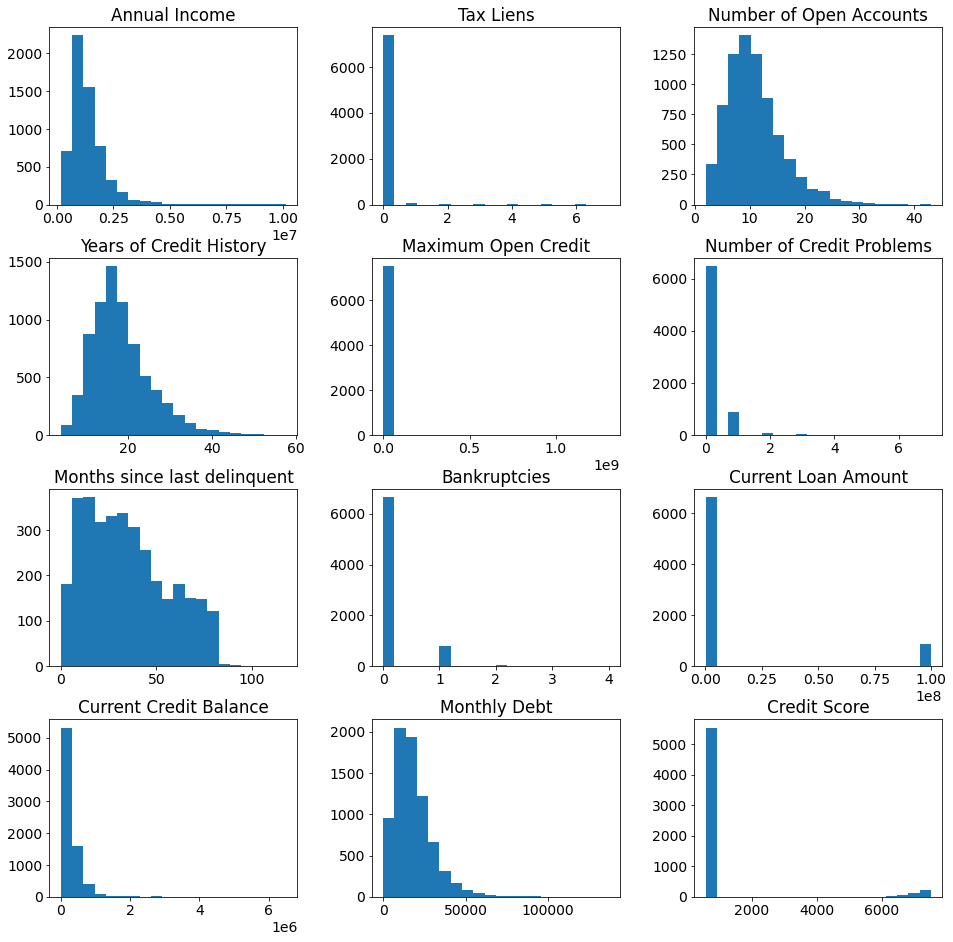

In [16]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False)
plt.show()

Выбросы в Current Loan Amount, Credit Score и Maximum Open Creadit 

### 2.2.4. Матрица корреляции <a class='anchor' id='corr_matrix'>

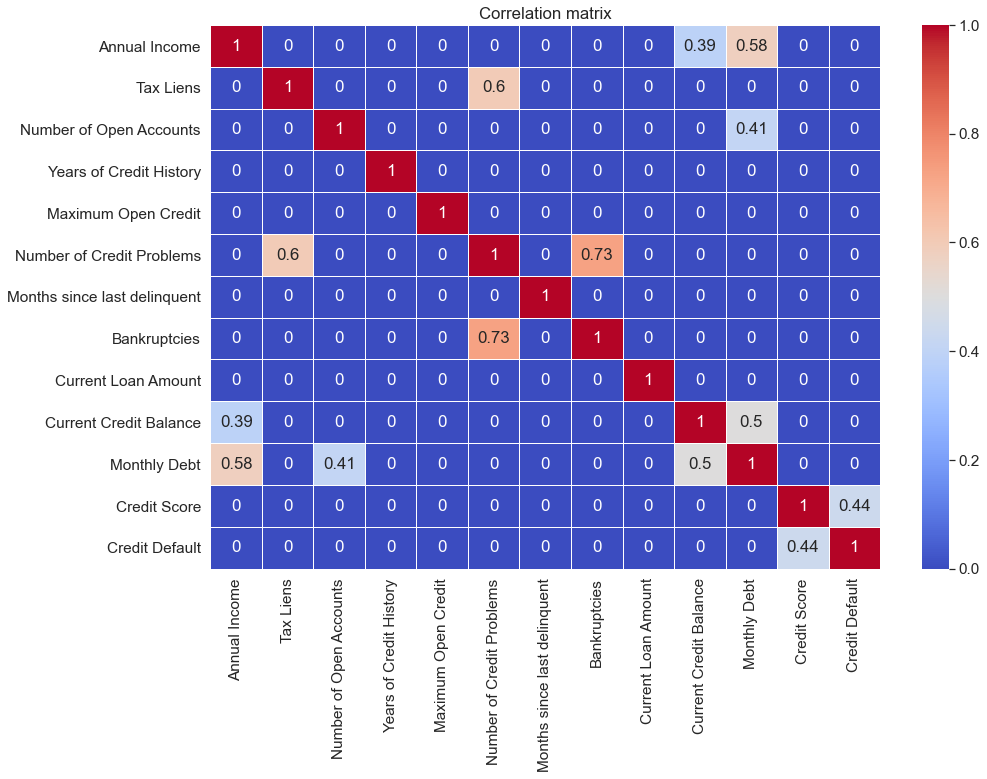

In [17]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Сильная линейная зависимоть признаков Bankruptcies и Number of Credit Problems

## 2.3. Корреляция целевой переменной с базовыми <a class='anchor' id='target_corr'>

In [18]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()

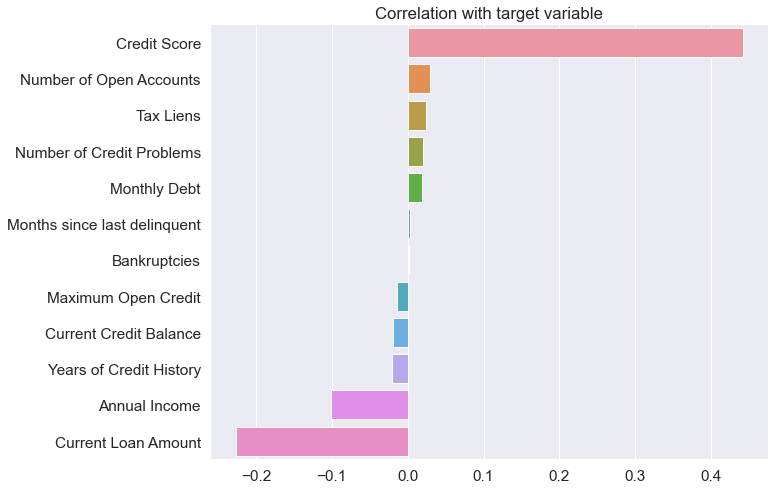

In [19]:
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Сильная прямая зависимость целевой переменной от Credit Score и обратная от Current Loan Amount

# 3. Обработка исходных данных <a class='anchor' id='prep'>

## 3.1. Обработка выбросов <a class='anchor' id='outlier'>

In [20]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### 3.1.1. Credit Score <a class='anchor' id='credit_score'>

In [21]:
# замена выбросов на значение в 10 раз меньше
train_df.loc[train_df['Credit Score'] > 2000, 'Credit Score'] = train_df['Credit Score'] * 0.1
train_df.loc[train_df['Credit Score'] > 2000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


In [22]:
test_df.loc[test_df['Credit Score'] > 2000, 'Credit Score'] = test_df['Credit Score'] * 0.1

### 3.1.2. Current Credit Balance <a class='anchor' id='current_credit_balance'>

In [23]:
train_df['Current Credit Balance'].quantile(.999), train_df['Current Credit Balance'].quantile(.01)

(3615437.0780001516, 1443.81)

In [24]:
train_df.loc[(train_df['Current Credit Balance'] < train_df['Current Credit Balance'].quantile(.01)) | (train_df['Current Credit Balance'] > train_df['Current Credit Balance'].quantile(.99))]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,14.0,0.0,debt consolidation,Short Term,165924.0,0.0,9021.0,738.0,0
93,Home Mortgage,NaN,10+ years,0.0,18.0,17.9,3028014.0,0.0,NaN,0.0,debt consolidation,Short Term,311168.0,2327443.0,55716.0,NaN,0
97,Rent,840541.0,6 years,0.0,6.0,14.8,427372.0,0.0,NaN,0.0,business loan,Short Term,99999999.0,1102.0,483.0,751.0,0
162,Home Mortgage,2131591.0,< 1 year,0.0,15.0,31.7,4191176.0,0.0,NaN,0.0,debt consolidation,Short Term,269258.0,3547262.0,20783.0,728.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7090,Home Mortgage,NaN,2 years,0.0,22.0,20.8,3298922.0,0.0,NaN,0.0,debt consolidation,Short Term,553630.0,1766430.0,40817.0,NaN,0
7124,Rent,NaN,1 year,0.0,4.0,11.0,0.0,0.0,50.0,0.0,debt consolidation,Short Term,134024.0,0.0,0.0,NaN,0
7278,Own Home,2418415.0,NaN,0.0,13.0,14.0,7453138.0,0.0,45.0,0.0,debt consolidation,Long Term,440088.0,4209659.0,29626.0,714.0,0
7377,Home Mortgage,1844292.0,10+ years,0.0,13.0,19.7,5784482.0,0.0,6.0,0.0,debt consolidation,Long Term,265078.0,1673558.0,12833.0,698.0,0


In [25]:
condition = (train_df['Current Credit Balance'].isna()) \
             | (train_df['Current Credit Balance'] == 0) \
             | (train_df['Current Credit Balance'] > train_df['Current Credit Balance'].quantile(.999)) \
             | (train_df['Current Credit Balance'] < train_df['Current Credit Balance'].quantile(.01))

# замена выбросов значений баланса на медиану
train_df['Current Credit Balance outlier'] = 0
train_df.loc[condition, 'Current Credit Balance outlier'] = 1

train_df.loc[condition, 'Current Credit Balance'] = train_df['Current Credit Balance'].median()

train_df.loc[train_df['Current Credit Balance outlier'] == 1]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Current Credit Balance outlier
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,209323.0,17.0,NaN,0,1
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,14.0,0.0,debt consolidation,Short Term,165924.0,209323.0,9021.0,738.0,0,1
97,Rent,840541.0,6 years,0.0,6.0,14.8,427372.0,0.0,NaN,0.0,business loan,Short Term,99999999.0,209323.0,483.0,751.0,0,1
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,NaN,0.0,small business,Short Term,218042.0,209323.0,5855.0,738.0,0,1
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,NaN,0.0,home improvements,Short Term,108042.0,209323.0,30340.0,742.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6851,Home Mortgage,2251728.0,10+ years,0.0,8.0,15.4,0.0,0.0,NaN,0.0,home improvements,Long Term,760452.0,209323.0,36778.0,725.0,0,1
7014,Home Mortgage,1223771.0,5 years,0.0,9.0,24.0,0.0,0.0,NaN,0.0,small business,Long Term,751454.0,209323.0,15348.0,737.0,1,1
7066,Home Mortgage,NaN,1 year,0.0,6.0,17.4,259160.0,0.0,18.0,0.0,other,Short Term,210584.0,209323.0,3728.0,NaN,0,1
7124,Rent,NaN,1 year,0.0,4.0,11.0,0.0,0.0,50.0,0.0,debt consolidation,Short Term,134024.0,209323.0,0.0,NaN,0,1


In [26]:
condition = (test_df['Current Credit Balance'].isna()) \
             | (test_df['Current Credit Balance'] == 0) \
             | (test_df['Current Credit Balance'] > test_df['Current Credit Balance'].quantile(.999)) \
             | (test_df['Current Credit Balance'] < test_df['Current Credit Balance'].quantile(.01))

test_df['Current Credit Balance outlier'] = 0
test_df.loc[condition, 'Current Credit Balance outlier'] = 1
test_df.loc[condition, 'Current Credit Balance'] = test_df['Current Credit Balance'].median()

### 3.1.3. Monthly Debt <a class='anchor' id='monthly_debt'>

In [27]:
condition = (train_df['Monthly Debt'].isna()) \
             | (train_df['Monthly Debt'] == 0) \
             | (train_df['Monthly Debt'] > train_df['Monthly Debt'].quantile(.999)) \
             | (train_df['Monthly Debt'] < train_df['Monthly Debt'].quantile(.01))

# замена выбросов значений задолженности за месяц на медиану
train_df['Monthly Debt outlier'] = 0
train_df.loc[condition, 'Monthly Debt outlier'] = 1

train_df.loc[condition, 'Monthly Debt'] = train_df['Monthly Debt'].median()

train_df.loc[train_df['Monthly Debt outlier'] == 1]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Current Credit Balance outlier,Monthly Debt outlier
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,209323.0,16076.5,NaN,0,1,1
97,Rent,840541.0,6 years,0.0,6.0,14.8,427372.0,0.0,NaN,0.0,business loan,Short Term,99999999.0,209323.0,16076.5,751.0,0,1,1
166,Home Mortgage,4580976.0,4 years,0.0,18.0,25.5,1553530.0,0.0,NaN,0.0,debt consolidation,Long Term,99999999.0,633289.0,16076.5,727.0,0,0,1
244,Rent,1325212.0,< 1 year,0.0,6.0,23.4,649770.0,0.0,NaN,0.0,moving,Short Term,99999999.0,45448.0,16076.5,745.0,0,0,1
270,Own Home,NaN,10+ years,0.0,11.0,14.0,558250.0,0.0,NaN,0.0,debt consolidation,Short Term,129206.0,24586.0,16076.5,NaN,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6940,Home Mortgage,NaN,5 years,0.0,4.0,26.2,132792.0,0.0,NaN,0.0,other,Long Term,348436.0,39919.0,16076.5,NaN,1,0,1
6946,Own Home,6492395.0,1 year,0.0,19.0,26.0,1406526.0,0.0,NaN,0.0,other,Short Term,322190.0,1169773.0,16076.5,707.0,0,0,1
7124,Rent,NaN,1 year,0.0,4.0,11.0,0.0,0.0,50.0,0.0,debt consolidation,Short Term,134024.0,209323.0,16076.5,NaN,0,1,1
7135,Rent,1914250.0,1 year,0.0,5.0,9.6,457864.0,0.0,NaN,0.0,home improvements,Short Term,99999999.0,13832.0,16076.5,747.0,0,0,1


In [28]:
condition = (test_df['Monthly Debt'].isna()) \
             | (test_df['Monthly Debt'] == 0) \
             | (test_df['Monthly Debt'] > test_df['Monthly Debt'].quantile(.999)) \
             | (test_df['Monthly Debt'] < test_df['Monthly Debt'].quantile(.01))

test_df['Monthly Debt outlier'] = 0
test_df.loc[condition, 'Monthly Debt outlier'] = 1
test_df.loc[condition, 'Monthly Debt'] = test_df['Monthly Debt'].median()

### 3.1.4. Current Loan Amount <a class='anchor' id='credit_loan_amount'>

In [29]:
train_df['Current Loan Amount'].value_counts()

99999999.0    870
218064.0        6
89298.0         6
216106.0        5
265826.0        5
             ... 
104324.0        1
201080.0        1
427812.0        1
665544.0        1
191136.0        1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [30]:
med_loan_by_purpose = train_df.groupby('Purpose', as_index=False).agg({'Current Loan Amount':'median'}).\
                                            rename(columns={'Current Loan Amount':'Med Amount By Purpose'})
med_loan_by_purpose_test = test_df.groupby('Purpose', as_index=False).agg({'Current Loan Amount':'median'}).\
                                            rename(columns={'Current Loan Amount':'Med Amount By Purpose'})

med_loan_by_purpose

,Purpose,Med Amount By Purpose
0,business loan,343838.0
1,buy a car,153813.0
2,buy house,331551.0
3,debt consolidation,324104.0
4,educational expenses,213719.0
5,home improvements,324027.0
6,major purchase,219087.0
7,medical bills,173492.0
8,moving,117612.0
9,other,206272.0


In [31]:
train_df_copy = train_df.merge(med_loan_by_purpose, on=['Purpose'], how='left')
test_df_copy = test_df.merge(med_loan_by_purpose_test, on=['Purpose'], how='left')

In [32]:
condition = (train_df['Current Loan Amount'].isna()) \
             | (train_df['Current Loan Amount'] == 99999999.0)

train_df['Current Loan Amount outlier'] = 0
train_df.loc[condition, 'Current Loan Amount outlier'] = 1
train_df.loc[condition, 'Current Loan Amount'] = train_df_copy.loc[train_df_copy['Purpose'] == train_df['Purpose'], 'Med Amount By Purpose']

In [33]:
condition = (test_df['Current Loan Amount'].isna()) \
             | (test_df['Current Loan Amount'] == 99999999.0)

test_df['Current Loan Amount outlier'] = 0
test_df.loc[condition, 'Current Loan Amount outlier'] = 1
test_df.loc[condition, 'Current Loan Amount'] = test_df_copy.loc[test_df_copy['Purpose'] == test_df['Purpose'], 'Med Amount By Purpose']

In [34]:
train_df.loc[train_df['Current Loan Amount outlier'] == 1]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Current Credit Balance outlier,Monthly Debt outlier,Current Loan Amount outlier
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,324104.0,47386.0,7914.0,749.0,0,0,0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,324104.0,308389.0,13651.0,742.0,0,0,0,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,324027.0,51623.0,2317.0,745.0,0,0,0,1
22,Rent,463790.0,NaN,0.0,6.0,28.3,288442.0,0.0,NaN,0.0,debt consolidation,Short Term,324104.0,157700.0,5063.0,738.0,0,0,0,1
27,Rent,1004055.0,8 years,0.0,7.0,14.5,328394.0,0.0,NaN,0.0,debt consolidation,Short Term,324104.0,195966.0,6041.0,734.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7441,Rent,1406836.0,1 year,0.0,12.0,22.6,2383260.0,0.0,NaN,0.0,debt consolidation,Short Term,324104.0,461054.0,7386.0,747.0,0,0,0,1
7445,Home Mortgage,1564384.0,6 years,0.0,21.0,17.3,1545016.0,0.0,NaN,0.0,other,Long Term,206272.0,1043442.0,32461.0,728.0,0,0,0,1
7464,Home Mortgage,1159152.0,6 years,0.0,14.0,22.0,389356.0,1.0,77.0,1.0,debt consolidation,Short Term,324104.0,49438.0,18257.0,737.0,0,0,0,1
7475,Rent,848426.0,10+ years,0.0,8.0,20.1,526306.0,0.0,12.0,0.0,debt consolidation,Short Term,324104.0,83638.0,16473.0,742.0,0,0,0,1


### 3.1.5. Maximum Open Credit <a class='anchor' id='maximum_open_credit'>

In [35]:
train_df['Maximum Open Credit'].quantile(.999), train_df['Maximum Open Credit'].quantile(.01)

(20328519.00200233, 17269.78)

In [36]:
train_df.loc[(train_df['Maximum Open Credit'] == 0)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Current Credit Balance outlier,Monthly Debt outlier,Current Loan Amount outlier
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,209323.0,16076.5,NaN,0,1,1,0
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,14.0,0.0,debt consolidation,Short Term,165924.0,209323.0,9021.0,738.0,0,1,0,0
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,NaN,0.0,small business,Short Term,218042.0,209323.0,5855.0,738.0,0,1,0,0
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,NaN,0.0,home improvements,Short Term,108042.0,209323.0,30340.0,742.0,0,1,0,0
309,Rent,1245792.0,3 years,0.0,5.0,22.4,0.0,0.0,58.0,0.0,major purchase,Long Term,338096.0,209323.0,16076.5,659.0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6593,Home Mortgage,NaN,8 years,0.0,10.0,13.0,0.0,0.0,NaN,0.0,debt consolidation,Long Term,672078.0,209323.0,8860.0,NaN,0,1,0,0
6851,Home Mortgage,2251728.0,10+ years,0.0,8.0,15.4,0.0,0.0,NaN,0.0,home improvements,Long Term,760452.0,209323.0,36778.0,725.0,0,1,0,0
7014,Home Mortgage,1223771.0,5 years,0.0,9.0,24.0,0.0,0.0,NaN,0.0,small business,Long Term,751454.0,209323.0,15348.0,737.0,1,1,0,0
7124,Rent,NaN,1 year,0.0,4.0,11.0,0.0,0.0,50.0,0.0,debt consolidation,Short Term,134024.0,209323.0,16076.5,NaN,0,1,1,0


In [37]:
condition = (train_df['Maximum Open Credit'].isna()) \
             | (train_df['Maximum Open Credit'] == 0) \
             | (train_df['Maximum Open Credit'] > train_df['Maximum Open Credit'].quantile(.999)) \
             | (train_df['Maximum Open Credit'] < train_df['Current Loan Amount'])

# замена выбросов значений максимального значения кредита на текущуюю задолженность
train_df['Maximum Open Credit outlier'] = 0
train_df.loc[condition , 'Maximum Open Credit outlier'] = 1
train_df.loc[condition , 'Maximum Open Credit'] = train_df['Current Loan Amount']

train_df.loc[train_df['Maximum Open Credit outlier'] == 1]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Current Credit Balance outlier,Monthly Debt outlier,Current Loan Amount outlier,Maximum Open Credit outlier
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,129734.0,1.0,NaN,1.0,...,Short Term,129734.0,209323.0,16076.5,NaN,0,1,1,0,1
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,572880.0,0.0,6.0,0.0,...,Long Term,572880.0,205333.0,17613.0,NaN,1,0,0,0,1
18,Home Mortgage,1401744.0,2 years,0.0,9.0,29.0,553586.0,0.0,40.0,0.0,...,Long Term,553586.0,201989.0,13434.0,695.0,1,0,0,0,1
19,Rent,1020072.0,2 years,0.0,6.0,12.5,309672.0,0.0,NaN,0.0,...,Short Term,309672.0,120517.0,14451.0,712.0,1,0,0,0,1
22,Rent,463790.0,NaN,0.0,6.0,28.3,324104.0,0.0,NaN,0.0,...,Short Term,324104.0,157700.0,5063.0,738.0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7485,Rent,2687664.0,< 1 year,0.0,14.0,16.7,466796.0,0.0,77.0,0.0,...,Short Term,466796.0,278711.0,44122.0,736.0,1,0,0,0,1
7487,Home Mortgage,1542952.0,10+ years,0.0,7.0,12.5,267982.0,0.0,59.0,0.0,...,Long Term,267982.0,198873.0,15430.0,695.0,1,0,0,0,1
7488,Rent,465405.0,5 years,0.0,5.0,7.7,129338.0,0.0,33.0,0.0,...,Short Term,129338.0,8721.0,13535.0,728.0,0,0,0,0,1
7491,Home Mortgage,2833185.0,6 years,0.0,18.0,21.3,437404.0,0.0,6.0,0.0,...,Short Term,437404.0,108889.0,61150.0,704.0,0,0,0,0,1


In [38]:
condition = (test_df['Maximum Open Credit'].isna()) \
             | (test_df['Maximum Open Credit'] == 0) \
             | (test_df['Maximum Open Credit'] > test_df['Maximum Open Credit'].quantile(.999)) \
             | (test_df['Maximum Open Credit'] < test_df['Current Loan Amount'])

test_df['Maximum Open Credit outlier'] = 0
test_df.loc[condition , 'Maximum Open Credit outlier'] = 1
test_df.loc[condition , 'Maximum Open Credit'] = test_df['Current Loan Amount']

## 3.2. Обработка пропусков <a class='anchor' id='nan'>

In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Home Ownership                  7500 non-null   object 
 1   Annual Income                   5943 non-null   float64
 2   Years in current job            7129 non-null   object 
 3   Tax Liens                       7500 non-null   float64
 4   Number of Open Accounts         7500 non-null   float64
 5   Years of Credit History         7500 non-null   float64
 6   Maximum Open Credit             7500 non-null   float64
 7   Number of Credit Problems       7500 non-null   float64
 8   Months since last delinquent    3419 non-null   float64
 9   Bankruptcies                    7486 non-null   float64
 10  Purpose                         7500 non-null   object 
 11  Term                            7500 non-null   object 
 12  Current Loan Amount             75

### 3.2.1. Annual Income   <a class='anchor' id='annual_income'>

In [40]:
# замена пропусков медианой
train_df['Annual Income nan'] = train_df['Annual Income'].isna() * 1
train_df.loc[(train_df['Annual Income'].isna()), 'Annual Income'] = train_df['Annual Income'].median()

train_df.loc[train_df['Annual Income nan'] == 1]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Current Credit Balance outlier,Monthly Debt outlier,Current Loan Amount outlier,Maximum Open Credit outlier,Annual Income nan
5,Rent,1168386.0,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,...,337304.0,165680.0,18692.0,NaN,1,0,0,0,0,1
8,Home Mortgage,1168386.0,5 years,0.0,17.0,15.7,129734.0,1.0,NaN,1.0,...,129734.0,209323.0,16076.5,NaN,0,1,1,0,1,1
9,Home Mortgage,1168386.0,1 year,0.0,10.0,24.6,572880.0,0.0,6.0,0.0,...,572880.0,205333.0,17613.0,NaN,1,0,0,0,1,1
10,Home Mortgage,1168386.0,< 1 year,0.0,7.0,11.5,256322.0,0.0,NaN,0.0,...,220858.0,187492.0,14592.0,NaN,0,0,0,0,0,1
16,Rent,1168386.0,7 years,0.0,6.0,17.8,899492.0,0.0,NaN,0.0,...,313038.0,538346.0,18844.0,NaN,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,Home Mortgage,1168386.0,10+ years,0.0,14.0,30.5,645062.0,0.0,45.0,0.0,...,188430.0,518662.0,23506.0,NaN,0,0,0,0,0,1
7492,Home Mortgage,1168386.0,10+ years,0.0,10.0,13.3,423984.0,0.0,NaN,0.0,...,332948.0,161481.0,20966.0,NaN,0,0,0,0,0,1
7494,Own Home,1168386.0,< 1 year,0.0,7.0,8.2,301554.0,0.0,NaN,0.0,...,290400.0,210938.0,5070.0,NaN,0,0,0,0,0,1
7498,Home Mortgage,1168386.0,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,...,615274.0,476064.0,37118.0,NaN,0,0,0,0,0,1


In [41]:
test_df['Annual Income nan'] = test_df['Annual Income'].isna() * 1
test_df.loc[(test_df['Annual Income'].isna()), 'Annual Income'] = test_df['Annual Income'].median()

### 3.2.2. Years in current job <a class='anchor' id='years_in_current_job'>

In [42]:
years_job_mode = train_df['Years in current job'].mode()
years_job_mode

0    10+ years
dtype: object

In [43]:
# замена пропусков модой
train_df['Years in current job nan'] = train_df['Years in current job'].isna() * 1
train_df.loc[train_df['Years in current job'].isna(), 'Years in current job'] = '10+ years'
train_df.loc[train_df['Years in current job nan'] == 1]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Current Credit Balance outlier,Monthly Debt outlier,Current Loan Amount outlier,Maximum Open Credit outlier,Annual Income nan,Years in current job nan
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,47386.0,7914.0,749.0,0,0,0,1,0,0,1
22,Rent,463790.0,10+ years,0.0,6.0,28.3,324104.0,0.0,NaN,0.0,...,157700.0,5063.0,738.0,0,0,0,1,1,0,1
24,Own Home,1168386.0,10+ years,0.0,12.0,25.0,1216336.0,0.0,61.0,0.0,...,818311.0,37530.0,NaN,0,0,0,0,0,1,1
58,Home Mortgage,992845.0,10+ years,0.0,17.0,21.2,1132054.0,0.0,NaN,0.0,...,294291.0,25483.0,739.0,0,0,0,0,0,0,1
60,Home Mortgage,1630029.0,10+ years,0.0,10.0,17.3,697114.0,0.0,NaN,0.0,...,260680.0,6181.0,714.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7368,Rent,408709.0,10+ years,0.0,13.0,14.0,403106.0,1.0,NaN,1.0,...,143773.0,3242.0,720.0,1,0,0,0,0,0,1
7409,Home Mortgage,1939349.0,10+ years,0.0,10.0,17.5,322652.0,0.0,61.0,0.0,...,56563.0,22949.0,750.0,0,0,0,0,0,0,1
7413,Rent,1784537.0,10+ years,0.0,11.0,20.1,449196.0,0.0,13.0,0.0,...,204250.0,22307.0,736.0,1,0,0,0,1,0,1
7439,Home Mortgage,671270.0,10+ years,0.0,12.0,20.6,324104.0,0.0,NaN,0.0,...,151278.0,6937.0,737.0,0,0,0,1,1,0,1


In [44]:
test_df['Years in current job nan'] = test_df['Years in current job'].isna() * 1
test_df.loc[test_df['Years in current job'].isna(), 'Years in current job'] = '10+ years'

### 3.2.3. Bankruptcies <a class='anchor' id='bankruptcies'>

In [45]:
# замена пропусков нулями (отсутсвие банкротств)
train_df['Bankruptcies nan'] = train_df['Bankruptcies'].isna() * 1
train_df.loc[(train_df['Bankruptcies'].isna()), 'Bankruptcies'] = 0

train_df.loc[train_df['Bankruptcies nan'] == 1]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Monthly Debt,Credit Score,Credit Default,Current Credit Balance outlier,Monthly Debt outlier,Current Loan Amount outlier,Maximum Open Credit outlier,Annual Income nan,Years in current job nan,Bankruptcies nan
100,Own Home,337079.0,1 year,0.0,9.0,39.6,644204.0,0.0,0.0,0.0,...,4326.0,734.0,0,0,0,1,0,0,0,1
256,Rent,857660.0,1 year,0.0,6.0,19.7,324104.0,0.0,0.0,0.0,...,3488.0,743.0,0,0,0,1,1,0,0,1
257,Home Mortgage,1168386.0,2 years,0.0,15.0,13.6,1556390.0,0.0,0.0,0.0,...,19613.0,NaN,0,0,0,0,0,1,0,1
898,Rent,739005.0,2 years,0.0,20.0,18.3,2177758.0,0.0,0.0,0.0,...,9669.0,732.0,1,0,0,0,0,0,0,1
1404,Rent,349391.0,< 1 year,0.0,4.0,12.7,11242.0,0.0,0.0,0.0,...,16076.5,747.0,0,1,1,0,1,0,0,1
3063,Rent,464474.0,10+ years,0.0,5.0,14.9,44814.0,0.0,0.0,0.0,...,16076.5,749.0,1,0,1,0,1,0,0,1
3252,Rent,832770.0,< 1 year,0.0,7.0,16.5,636856.0,0.0,0.0,0.0,...,16076.5,750.0,0,0,1,0,0,0,0,1
3351,Home Mortgage,2226192.0,8 years,0.0,14.0,23.3,792836.0,0.0,73.0,0.0,...,23746.0,674.0,0,0,0,0,0,0,0,1
3401,Rent,326154.0,6 years,0.0,2.0,19.1,206272.0,0.0,77.0,0.0,...,16076.5,712.0,0,1,1,1,1,0,0,1
3496,Rent,233567.0,1 year,0.0,7.0,11.7,210166.0,0.0,0.0,0.0,...,16076.5,746.0,0,1,1,0,1,0,0,1


In [46]:
test_df['Bankruptcies nan'] = test_df['Bankruptcies'].isna() * 1
test_df.loc[(test_df['Bankruptcies'].isna()), 'Bankruptcies'] = 0

### 3.2.4. Credit Score <a class='anchor' id='credit_score_nan'>

In [47]:
# замена пропусков медианой
train_df['Credit Score nan'] = train_df['Credit Score'].isna() * 1
train_df.loc[(train_df['Credit Score'].isna()), 'Credit Score'] = train_df['Credit Score'].median()

train_df.loc[train_df['Credit Score nan'] == 1]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Score,Credit Default,Current Credit Balance outlier,Monthly Debt outlier,Current Loan Amount outlier,Maximum Open Credit outlier,Annual Income nan,Years in current job nan,Bankruptcies nan,Credit Score nan
5,Rent,1168386.0,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,...,729.0,1,0,0,0,0,1,0,0,1
8,Home Mortgage,1168386.0,5 years,0.0,17.0,15.7,129734.0,1.0,NaN,1.0,...,729.0,0,1,1,0,1,1,0,0,1
9,Home Mortgage,1168386.0,1 year,0.0,10.0,24.6,572880.0,0.0,6.0,0.0,...,729.0,1,0,0,0,1,1,0,0,1
10,Home Mortgage,1168386.0,< 1 year,0.0,7.0,11.5,256322.0,0.0,NaN,0.0,...,729.0,0,0,0,0,0,1,0,0,1
16,Rent,1168386.0,7 years,0.0,6.0,17.8,899492.0,0.0,NaN,0.0,...,729.0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,Home Mortgage,1168386.0,10+ years,0.0,14.0,30.5,645062.0,0.0,45.0,0.0,...,729.0,0,0,0,0,0,1,0,0,1
7492,Home Mortgage,1168386.0,10+ years,0.0,10.0,13.3,423984.0,0.0,NaN,0.0,...,729.0,0,0,0,0,0,1,0,0,1
7494,Own Home,1168386.0,< 1 year,0.0,7.0,8.2,301554.0,0.0,NaN,0.0,...,729.0,0,0,0,0,0,1,0,0,1
7498,Home Mortgage,1168386.0,10+ years,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,...,729.0,0,0,0,0,0,1,1,0,1


In [48]:
test_df['Credit Score nan'] = test_df['Credit Score'].isna() * 1
test_df.loc[(test_df['Credit Score'].isna()), 'Credit Score'] = test_df['Credit Score'].median()

### 3.2.5. Months since last delinquent <a class='anchor' id='month_since_last_delinquent'>

In [49]:
# замена пропусков нулями (отуствие задолженности)
train_df['Months since last delinquent nan'] = train_df['Months since last delinquent'].isna() * 1
train_df.loc[(train_df['Months since last delinquent'].isna()), 'Months since last delinquent'] = 0

train_df.loc[train_df['Months since last delinquent nan'] == 1]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Default,Current Credit Balance outlier,Monthly Debt outlier,Current Loan Amount outlier,Maximum Open Credit outlier,Annual Income nan,Years in current job nan,Bankruptcies nan,Credit Score nan,Months since last delinquent nan
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,0,0,0,1,0,0,1,0,0,1
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7494,Own Home,1168386.0,< 1 year,0.0,7.0,8.2,301554.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,1
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,129360.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
7498,Home Mortgage,1168386.0,10+ years,0.0,21.0,26.5,1141250.0,0.0,0.0,0.0,...,0,0,0,0,0,1,1,0,1,1


In [50]:
test_df['Months since last delinquent nan'] = test_df['Months since last delinquent'].isna() * 1
test_df.loc[(test_df['Months since last delinquent'].isna()), 'Months since last delinquent'] = 0

# 4. Построение новых признаков <a class='anchor' id='new_features'>

### 4.1. Years in current job num <a class='anchor' id='years_num'>

In [51]:
train_df['Years in current job'].unique()

array(['10+ years', '8 years', '6 years', '7 years', '5 years', '1 year',
       '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

In [52]:
years_to_numbers = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5,
                    '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}

# перевод значений признака в числа
train_df['Years in current job num'] = train_df['Years in current job'].replace(years_to_numbers)
train_df['Years in current job num'].astype(int)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Credit Balance outlier,Monthly Debt outlier,Current Loan Amount outlier,Maximum Open Credit outlier,Annual Income nan,Years in current job nan,Bankruptcies nan,Credit Score nan,Months since last delinquent nan,Years in current job num
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,0,0,1,0,0,1,0,0,1,10
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,10
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,1,8
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,1,6
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,8


In [53]:
test_df['Years in current job num'] = test_df['Years in current job'].replace(years_to_numbers)
test_df['Years in current job num'].astype(int)

0        4
1        1
2        3
3       10
4        6
        ..
2495    10
2496     2
2497     2
2498    10
2499    10
Name: Years in current job num, Length: 2500, dtype: int32

### 4.2. Tax Liens <a class='anchor' id='tax_liens'>

In [54]:
# перевод признака в бинарный (есть или нет налоговые обременения)
train_df.loc[train_df['Tax Liens'] > 0, 'Tax Liens'] = 1
test_df.loc[test_df['Tax Liens'] > 0, 'Tax Liens'] = 1

### 4.3. Number of Credit Problems <a class='anchor' id='number_of_credit_problems'>

In [55]:
# перевод признака в бинарный (есть или нет кредитные проблемы)
train_df.loc[train_df['Number of Credit Problems'] > 0, 'Number of Credit Problems'] = 1
test_df.loc[test_df['Number of Credit Problems'] > 0, 'Number of Credit Problems'] = 1

### 4.4. Bankruptcies <a class='anchor' id='bankruptcies_bin'>

In [56]:
# перевод признака в бинарный (есть или нет банкротства)
train_df.loc[train_df['Bankruptcies'] > 0, 'Bankruptcies'] = 1
test_df.loc[test_df['Bankruptcies'] > 0, 'Bankruptcies'] = 1

### 4.5. Term <a class='anchor' id='term'>

In [57]:
# перевод признака в бинарный (короткий или долгий срок кредита)
binary_to_numbers = {'Short Term': 0, 'Long Term': 1}

train_df['Binary Term'] = train_df['Term'].replace(binary_to_numbers)
test_df['Binary Term'] = test_df['Term'].replace(binary_to_numbers)

### 4.6. Monthly Debt Share <a class='anchor' id='monthly_debt_share'>

In [58]:
# доля ежемесячного платежа относительно месячного дохода
train_df['Monthly Debt Share'] = 0
train_df['Monthly Debt Share'] = (train_df['Monthly Debt'] / (train_df['Annual Income'] /12)) * 100
train_df[train_df['Monthly Debt Share'] > 80].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Loan Amount outlier,Maximum Open Credit outlier,Annual Income nan,Years in current job nan,Bankruptcies nan,Credit Score nan,Months since last delinquent nan,Years in current job num,Binary Term,Monthly Debt Share
2064,Home Mortgage,1168386.0,10+ years,0.0,17.0,21.1,1540594.0,0.0,70.0,0.0,...,0,0,1,0,0,1,0,10,0,85.716193
3310,Rent,191577.0,10+ years,0.0,3.0,24.3,270754.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,10,0,100.699980
3496,Rent,233567.0,1 year,0.0,7.0,11.7,210166.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,1,0,82.596428
4240,Rent,164597.0,7 years,0.0,17.0,14.1,2086216.0,0.0,20.0,0.0,...,0,0,0,0,0,0,0,7,0,117.206267
5867,Rent,225112.0,3 years,0.0,5.0,9.0,204424.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,3,0,85.698674


In [59]:
test_df['Monthly Debt Share'] = 0
test_df['Monthly Debt Share'] = (test_df['Monthly Debt'] / (test_df['Annual Income'] /12)) * 100

### 4.7. Loan Amount Share <a class='anchor' id='loan_amount_share'>

In [60]:
# доля суммы задолженности относительно годового дохода
train_df['Loan Amount Share'] = 0
train_df['Loan Amount Share'] = train_df['Current Loan Amount'] / train_df['Annual Income'] * 100
train_df[train_df['Loan Amount Share'] > 80].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Maximum Open Credit outlier,Annual Income nan,Years in current job nan,Bankruptcies nan,Credit Score nan,Months since last delinquent nan,Years in current job num,Binary Term,Monthly Debt Share,Loan Amount Share
655,Rent,389234.0,7 years,0.0,4.0,21.7,324104.0,0.0,0.0,0.0,...,1,0,0,0,0,1,7,0,7.621123,83.267135
1767,Own Home,269534.0,10+ years,0.0,6.0,24.5,324104.0,0.0,50.0,0.0,...,1,0,1,0,0,0,10,0,21.000690,120.246054
2215,Rent,315419.0,7 years,0.0,10.0,8.7,324104.0,0.0,36.0,0.0,...,1,0,0,0,0,0,7,0,20.098979,102.753480
2786,Rent,321328.0,10+ years,0.0,8.0,8.3,324104.0,1.0,0.0,1.0,...,1,0,1,0,0,1,10,0,11.801026,100.863915
3496,Rent,233567.0,1 year,0.0,7.0,11.7,210166.0,0.0,0.0,0.0,...,1,0,0,1,0,0,1,0,82.596428,89.981033


In [61]:
test_df['Loan Amount Share'] = 0
test_df['Loan Amount Share'] = test_df['Current Loan Amount'] / test_df['Annual Income'] * 100

# 5. Сохранение обработанных данных <a class='anchor' id='backup'>

In [62]:
PREPARED_TRAIN_DS_PATH = './train_prepared.csv'
PREPARED_TEST_DS_PATH = './test_prepared.csv'

In [63]:
train_df.to_csv(PREPARED_TRAIN_DS_PATH, index=False, encoding='utf-8', sep=',')
test_df.to_csv(PREPARED_TEST_DS_PATH, index=False, encoding='utf-8', sep=',')

# 6. Отбор признаков <a class='anchor' id='feature_select'>

In [64]:
train_df = pd.read_csv(PREPARED_TRAIN_DS_PATH)
test_df = pd.read_csv(PREPARED_TEST_DS_PATH)
col_list = train_df.copy()

In [65]:
col_list.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Current Credit Balance outlier',
 'Monthly Debt outlier',
 'Current Loan Amount outlier',
 'Maximum Open Credit outlier',
 'Annual Income nan',
 'Years in current job nan',
 'Bankruptcies nan',
 'Credit Score nan',
 'Months since last delinquent nan',
 'Years in current job num',
 'Binary Term',
 'Monthly Debt Share',
 'Loan Amount Share']

In [66]:
FEATURE_NAMES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts',
                 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
                 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

NEW_FEATURE_NAMES = ['Current Credit Balance outlier', 'Monthly Debt outlier', 'Current Loan Amount outlier',
                     'Maximum Open Credit outlier', 'Annual Income nan', 'Years in current job nan',
                     'Bankruptcies nan', 'Credit Score nan']

TARGET_NAME = 'Credit Default'

In [67]:
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts',
                     'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                     'Credit Score', 'Current Credit Balance outlier', 'Monthly Debt outlier',
                     'Current Loan Amount outlier', 'Maximum Open Credit outlier', 'Annual Income nan',
                     'Years in current job nan', 'Bankruptcies nan', 'Credit Score nan',
                     'Years in current job num', 'Binary Term', 'Monthly Debt Share', 'Loan Amount Share']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [68]:
X = train_df.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y = train_df[TARGET_NAME]

# 7. Разбиение на train и test <a class='anchor' id='ds_separating'>

In [69]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y
                                                   )

display(y_train.value_counts(normalize=True), y_valid.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

# 8. Построение модели <a class='anchor' id='catb'>

## 8.1. Подбор параметров модели<a class='anchor' id='parameters'>

In [70]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

In [71]:
model_catb = catb.CatBoostClassifier(silent=True,
                                     random_state=42,
#                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     early_stopping_rounds=20
                                     )

In [72]:
params = {'iterations':[5, 10, 20, 50, 200, 500],
          'reg_lambda': [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          'max_depth':[3, 5, 7, 10]}

In [73]:
cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

In [74]:
# %%time
# grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

## 8.2. Обучение и оценка итоговой модели <a class='anchor' id='fin_model'>

In [75]:
model_catb = catb.CatBoostClassifier(silent=True,
                                     random_state=42,
                                     max_depth=3,
                                     iterations=250,
                                     reg_lambda=30,
#                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, disbalance]
                                     )

model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.60      0.70      3771
           1       0.42      0.73      0.53      1479

    accuracy                           0.64      5250
   macro avg       0.63      0.67      0.62      5250
weighted avg       0.73      0.64      0.66      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.60      0.70      1616
           1       0.41      0.71      0.52       634

    accuracy                           0.63      2250
   macro avg       0.63      0.66      0.61      2250
weighted avg       0.72      0.63      0.65      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               964  652
1               181  453


In [76]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_catb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
14,Current Loan Amount outlier,66.146805
22,Binary Term,7.244349
11,Credit Score,5.716217
24,Loan Amount Share,4.710724
0,Annual Income,3.367962
23,Monthly Debt Share,3.034349
4,Maximum Open Credit,2.029886
3,Years of Credit History,1.597407
9,Current Credit Balance,0.842937
2,Number of Open Accounts,0.769464


# 9. Прогнозирование на тестовом датасете <a class='anchor' id='predictions'>

In [77]:
submit = pd.read_csv('./sample_submission.csv') # пример требуемого результата
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [78]:
test_df_copy = test_df.drop(columns=['Home Ownership','Years in current job', 'Purpose', 'Term'])
test_df_copy.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Maximum Open Credit outlier,Annual Income nan,Years in current job nan,Bankruptcies nan,Credit Score nan,Months since last delinquent nan,Years in current job num,Binary Term,Monthly Debt Share,Loan Amount Share
0,1178475.0,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,162470.0,105906.0,...,0,1,0,0,1,0,4,0,6.937440,13.786461
1,231838.0,0.0,6.0,32.7,78298.0,0.0,8.0,0.0,78298.0,46037.0,...,1,0,0,0,0,0,1,0,11.998033,33.772721
2,1152540.0,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,200178.0,146490.0,...,0,0,0,0,0,1,3,0,19.500234,17.368421
3,1220313.0,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,217382.0,213199.0,...,0,0,0,0,0,0,10,0,27.100260,17.813627
4,2340952.0,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,777634.0,425391.0,...,0,0,0,0,0,1,6,1,21.839833,33.218708


In [79]:
predictions = model_catb.predict(test_df_copy)
predictions

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [80]:
submit['Credit Default'] = predictions # замена целевой переменной в файле с примером результата
submit.head()

,Id,Credit Default
0,0,0
1,1,1
2,2,1
3,3,0
4,4,1


In [81]:
submit.to_csv('catb_submit.csv', index=False)

In [82]:
result_view = pd.read_csv('./catb_submit.csv') # для проверки результата
result_view.head()

,Id,Credit Default
0,0,0
1,1,1
2,2,1
3,3,0
4,4,1
